# Chapter 7: Finetuning To Follow Instructions

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library 画图的
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
tiktoken version: 0.8.0
torch version: 2.5.1+cu121
tqdm version: 4.66.6
tensorflow version: 2.18.0


## 7.1 指令微调简介
- 在第5章中，我们看到，对LLM（大语言模型）的预训练涉及一种逐字生成的训练过程。
- 因此，预训练的LLM擅长文本补全，但并不擅长遵循指令。
- 在本章中，我们将教会LLM更好地遵循指令。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>
- 下面是本章的主题
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 准备用于监督指令微调的数据集
- 我们将使用为本章准备的一个指令数据集。

In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 从上方的JSON文件加载的数据列表中的每个条目都是以下形式的字典：

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- 请注意，input字段可以为空：

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 指令微调通常被称为“监督指令微调”supervised instruction finetuning，因为它涉及对一个显式提供输入-输出对的数据集进行训练。
- 将这些条目格式化为LLM的输入有多种方式；下图展示了用于训练Alpaca(https://crfm.stanford.edu/2023/03/13/alpaca.html)和Phi-3(https://arxiv.org/abs/2404.14219) LLM的两个示例格式。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>
- 这章我们用Alpaca-style prompt formatting，它是original prompt template for instruction finetuning
- 下面格式化我们给LLM传入的输入

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
#A formatted response with input field
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
#formatted response without an input field
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节准备PyTorch数据加载器之前，我们将数据集分为训练集、验证集和测试集。

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据组织为训练批次
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>
- 我们通过以下几个步骤处理数据集批处理，如下图所示：
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>
- 首先，我们实现了一个 `InstructionDataset`类，用于对数据集中的所有输入进行预处理，类似于第6章中的`SpamDataset`。

In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- 与第6章类似，我们希望在一个批次中收集多个训练样本以加速训练；这需要将所有输入填充到相似的长度。
- 同样类似于上一章，我们使用<|endoftext|>作为填充标记。

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 在第6章中，我们将数据集中所有样本填充到相同长度。
    - 在这里，我们采用了一种更复杂的方法，开发了一个自定义的“collate”函数，可以传递给数据加载器。
    - 这个自定义collate函数将每个批次中的训练样本填充到相同长度（但不同批次可以具有不同长度）。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    #找到批次中最长的序列长度，并额外加 1,是为了在每个序列末尾添加一个 <|endoftext|> 标记。
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs 创建空列表用于存储填充后的序列
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        #在当前序列的末尾 Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token移除多余的填充标记
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1]) #去掉最后一个多余的填充标记
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>


- 在上面，我们只返回了LLM的输入；然而，对于LLM的训练，我们还需要target values
- 类似于LLM的预训练，目标是将输入向右移动1个位置，这样LLM就可以学习预测下一个标记。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 接下来，我们引入一个ignore_index值，用于将所有填充标记ID替换为一个新值；ignore_index的目的是在损失函数中忽略填充值（稍后会详细讨论）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- 具体来说，这意味着我们将对应于50256的标记ID替换为-100，但是第一个不会换，如下所示：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- （此外，我们还引入了allowed_max_length，以防我们想限制样本长度；这对于您计划使用自己超过GPT-2模型支持的1024标记上下文大小的数据集时非常有用）。

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        #除了第一个都替换
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()  
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length  
        # 如果限定了最大长度就截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- 让我们看看将50256替换为-100的作用。
- 为了说明，假设我们有一个小型分类任务，具有两个类别标签0和1，类似于第6章。
- 如果我们有以下logits值（模型最后一层的输出），我们计算如下损失：

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 现在加入一个训练例子，会影响loss

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 看看如果把所有 分类标签为1的样例换成-100 会发生什么


In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 可以看到，这3个训练样本的最终损失与我们从2个训练样本计算的损失相同，这意味着交叉熵损失函数忽略了带有标签-100的训练样本。
- 默认情况下，PyTorch的cross_entropy(..., ignore_index=-100)设置会忽略标签为-100的样本。

- 使用这个-100的ignore_index，我们可以忽略用于填充训练样本以达到相同长度的额外文本结束标记（padding token）。
- 然而，我们不希望忽略第一个文本结束标记（50256）的实例，因为它可以帮助向LLM指示响应何时完成。
- 在实践中，通常也会屏蔽与指令对应的目标标记ID，如下图所示（这是一个推荐的读者练习，建议在完成本章后尝试）。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 为instruction dataset创建data loaders
- 在本节中，我们将使用 InstructionDataset 类和 custom_collate_fn 函数来实例化训练集、验证集和测试集的数据加载器。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>
- 上述 custom_collate_fn 函数的另一个改进是：我们现在直接将数据移动到目标设备（例如 GPU），而不是在主训练循环中完成这一步操作。
- 这样可以提高效率，因为在将 custom_collate_fn 作为数据加载器的一部分时，这一步可以作为后台进程执行。
- 使用 Python 的 functools 标准库中的 partial 函数，我们创建了一个新的函数，将原函数的 device 参数预先填充。

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 接下来，我们与前几章类似地实例化数据加载器，不同之处在于我们现在为批处理过程提供了自定义的 collate 函数。 

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123) #可复现性

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    #collate函数将每个批次中的训练样本填充到相同长度（但不同批次可以具有不同长度）
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 让我们看一下生成的输入和目标批次的维度。

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 从上面的输出可以看到，所有批次的大小都是 8，但长度不同，这与预期一致。

- 我们还可以通过打印输入批次中第一个训练样本的内容，仔细检查它是否包含 <|endoftext|> 填充值（对应 token ID 为 50256）。

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- 同样，我们可以通过打印目标数据中的内容，确认是否包含 -100 占位符 token。

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 加载预训练 LLM
- 在本节中，我们将使用第 5.5 节和第 6.4 节中的代码加载一个预训练的 GPT 模型。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>
- 不过，这次我们不是加载最小的 124M 参数模型，而是加载中等版本的 355M 参数模型，因为 124M 的模型太小，无法通过指令微调获得合理的结果。

In [28]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


- 在下一节开始微调模型之前，我们可以先看一下它在验证任务中的表现。

In [29]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- 需要注意的是，我们在之前章节中使用的 generate 函数会返回合并后的输入和输出文本，这在上一节中方便了可读文本的创建。
- 为了提取单独的响应部分，我们可以从生成的 generated_text 中减去指令的长度。

In [31]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 从结果可以看出，模型还不具备遵循指令的能力；它虽然生成了一个“Response”部分，但只是简单地重复了原始输入句子以及指令。

## 7.6 在指令数据上微调 LLM
- 在本节中，我们对模型进行微调。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>
- 需要注意的是，我们可以重用之前章节中用来计算损失和进行训练的所有函数。

In [32]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- 在开始训练之前，让我们先计算训练集和验证集的初始损失（与之前章节一样，我们的目标是最小化损失）。

In [33]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.82590970993042
Validation loss: 3.761934280395508


- 由于我们使用了更大的模型（355M 参数，而不是 124M 参数），训练成本比之前的章节更高。
- 以下是各种设备的运行时间参考（如果在兼容的 GPU 设备上运行此笔记本，无需更改代码）。
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |


- 我使用了“gpt2-medium (355M)”模型运行了此笔记本。

In [34]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

- 从上述输出可以看出，模型训练效果良好，从减少的训练损失和验证损失值可以看出来。

- 此外，从每个 epoch 结束后打印的响应文本可以看出，模型能够正确遵循指令，例如将输入句子“厨师每天做饭”（The chef cooks the meal every day.）转换为被动语态“这顿饭每天由厨师烹饪”（The meal is cooked every day by the chef.）。（我们将在后面的章节中正式格式化并评估这些响应。）
- 最后，让我们看一下训练和验证损失曲线。

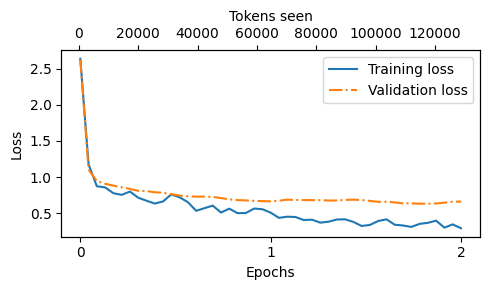

In [35]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从曲线可以看出，第一轮训练 epoch 的开始阶段损失急剧下降，这意味着模型开始快速学习。
- 我们可以看到，经过大约 1 个训练 epoch 后，出现了轻微的过拟合。
## 7.7 Extracting and saving responses
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>
- 在本节中，我们将保存测试集的响应，以便在下一节进行评分，同时保存一份模型的副本以供将来使用。
- 但首先，让我们简要查看一下微调模型生成的响应。

In [36]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- 正如我们从测试集的指令、给定的响应以及模型的响应中可以看到的，模型的表现相对较好。

- 对于第一条和最后一条指令，模型的回答显然是正确的。

- 第二个答案也很接近；模型给出的答案是“积云”而不是“雷雨云”（不过需要注意的是，积云可以发展成雷雨云，而雷雨云能够产生雷暴）。

- 最重要的是，我们可以看到，模型的评估并不像上一章那样简单，只需计算正确的垃圾邮件/非垃圾邮件标签的百分比来获得分类准确率。

- 在实际应用中，指令微调的LLM（如聊天机器人）通常通过多种方法进行评估：

    - 短答案和多选基准，如MMLU（“衡量大规模多任务语言理解”，测试模型的知识（https://arxiv.org/abs/2009.03300 ）；
    - 与其他LLM的人工偏好比较，如LMSYS聊天机器人竞技场（https://arena.lmsys.org ）；
    - 自动化对话基准，其中使用另一个LLM（如GPT-4）来评估响应，如AlpacaEval（https://tatsu-lab.github.io/alpaca_eval/ ）。
- 在下一节中，我们将采用类似于AlpacaEval的方法，使用另一个LLM来评估我们的模型响应；不过，我们将使用自己的测试集，而不是公开可用的基准数据集。
- 为此，我们将模型响应添加到test_data字典中，并将其保存为“instruction-data-with-response.json”文件进行记录，以便在需要时加载并在单独的Python会话中进行分析。

In [37]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [02:34<00:00,  1.41s/it]


- 让我们重新检查其中一条条目，查看响应是否已正确添加到test_data字典中。最后，我们还将保存模型，以防我们将来需要重用它。

In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [39]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 评估微调的LLM
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>
 

- 在本节中，我们使用另一个更大的LLM自动化评估微调后的LLM响应。
- 特别地，我们使用Meta AI的一个微调指令的8亿参数Llama 3模型，它可以通过ollama（https://ollama.com ）本地运行。 （如果您更喜欢使用像GPT-4这样的更强大的LLM通过OpenAI API，请参见llm-instruction-eval-openai.ipynb笔记本）。

- Ollama是一个高效运行LLM的应用程序，它是一个封装在llama.cpp（https://github.com/ggerganov/llama.cpp ）中的工具，后者实现了用纯C/C++编写的LLM，以最大化效率。
- 需要注意的是，它是一个用于生成文本（推理）的LLM工具，而不是用于训练或微调LLM。

- 在运行下面的代码之前，请访问https://ollama.com 并按照说明安装ollama（例如，点击“下载”按钮并下载适合您的操作系统的ollama应用程序）。

- 对于macOS和Windows用户，点击下载的ollama应用程序；如果它提示您安装命令行使用，请选择“是”。
- Linux用户可以使用ollama网站上提供的安装命令。

- 通常，在我们可以从命令行使用ollama之前，必须启动ollama应用程序或在另一个终端中运行ollama serve。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>

- 在另一个终端中运行ollama应用程序或ollama serve后，在命令行中执行以下命令来尝试运行8亿参数的Llama 3模型（该模型占用4.7 GB存储空间，首次执行此命令时会自动下载）。


```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```



- 需要注意的是，llama3指的是微调过的8亿参数Llama 3模型。

- 使用“llama3”模型（一个8B参数模型）需要16 GB的RAM；如果您的机器不支持此要求，您可以尝试较小的模型，例如3.8B参数的phi-3模型，只需要8 GB的RAM， `model = "phi-3"`。

- 另外，如果您的机器支持，您还可以使用更大的70亿参数Llama 3模型，将llama3替换为llama3:70b。

- 下载完成后，您将看到一个命令行提示，允许您与模型聊天。
- 尝试一个类似“Llamas吃什么？”的提示，应该会返回类似以下的输出。您可以通过输入/bye结束此会话。


```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```



- 可以用input  `/bye` 来结束这个session
- 以下代码会在继续使用ollama评估我们在上一节生成的测试集响应之前，检查ollama会话是否正常运行。


In [49]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [50]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 现在，除了之前用于与模型交互的ollama run命令，您还可以通过其REST API在Python中使用以下函数与模型交互。

- 在运行本笔记本中的下一个单元格之前，请确保ollama仍在运行（前面的代码单元格应该打印出“Ollama running: True”）。

- 接下来，运行以下代码单元格以查询模型。

In [54]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and digestive system.

In the wild, llamas would typically roam in herds, grazing on whatever plants are available in their natural habitat. In captivity, llama owners should provide a b

- 通过我们定义的query_model函数，我们可以评估微调后的模型的响应；让我们在之前查看过的前三个测试集响应上试一试。


In [55]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might not immediately think of bullets when they hear "fast", whereas lightning is often an intuitive comparison for speed. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea that the car is very quick!

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunde

- 正如我们所看到的，Llama 3模型提供了合理的评估，如果模型没有完全正确，它也会给出部分分数，正如我们在“积云”答案中看到的那样。

- 需要注意的是，之前的提示返回了非常冗长的评估verbose evaluations；我们可以调整提示生成一个介于0到100之间的整数响应（其中100是最佳），以便计算模型的平均分数。

- 在M3 MacBook Air笔记本上，评估测试集中的110个条目大约需要1分钟。

In [56]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|███████████████████████████████████████████████████████████████| 110/110 [04:15<00:00,  2.32s/it]

Number of scores: 110 of 110
Average score: 48.73




- 我们的模型平均得分超过50，这可以作为参考点，用来将模型与其他模型进行比较，或者尝试其他训练设置，看看是否能提高模型表现。

- 需要注意的是，ollama在不同操作系统上的表现并非完全确定（截至本编写时），因此您得到的分数可能会与上述显示的略有不同。

- 作为参考，原始的Llama 3 8B基础模型得分为58.51，Llama 3 8B指令模型得分为82.65。

## 7.9 总结
### 7.9.1 接下来是什么
- 这是本书的最后一章。
- 我们已经覆盖了 LLM 开发周期中的主要步骤：实现一个 LLM 的架构、预训练 LLM，以及对其进行微调。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>
- 在本章描述的指令微调之后，有时还会进行一个可选步骤：偏好微调（preference finetuning）。

- 偏好微调的过程对定制模型以更好地符合特定用户偏好非常有用。如果对此感兴趣，可以参考 GitHub 仓库中 ../04_preference-tuning-with-dpo 文件夹中的内容。

- 此外，本仓库还包含大量额外的补充材料，可能会让您感兴趣。有关更多信息，请参阅此仓库的 README 页面中的 Bonus Material 部分。



## 7.9.2 在快速发展的领域中保持更新
这一节没有代码。

### 7.9.3 最后的话
希望您享受了从零实现一个 LLM 的旅程，并亲手编写了预训练和微调函数。

在我看来，从头实现一个 LLM 是理解其工作原理的最佳方式；我希望通过这种方法，您对 LLM 有了更深入的理解。

尽管本书以教育为目的，但您可能对在实际应用中使用不同的、更强大的 LLM 感兴趣。

为此，您可以考虑一些流行工具，例如 axolotl 或 LitGPT，这些工具的开发我也参与了。